<a href="https://colab.research.google.com/github/SteffanBurnette/TensorFlow-/blob/Convolutional-Neural-Networks/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Transfer learning with tensorflow Part 1: Feature Extraction

**Transfer Learning** is leveraging a working models existing architecture and learned patterns for our own problems.

There are two main benefits:
* Can leverage an existing **neural network architecture** proven to work on problems similar to our own.
* Can leverage a **working neural network architecture** which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [1]:
!nvidia-smi


Fri Feb  2 21:36:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy


#Download and becoming one with the data

In [3]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2024-02-02 21:36:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.182.207, 64.233.183.207, 173.194.193.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.182.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   150MB/s    in 1.1s    

2024-02-02 21:36:23 (150 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:

# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

### Creating Data Loaders(Preparing the data)

We'll use the `ImageDataGenerator` class to load in our images into batches.

In [5]:
#Set up the data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
#When something is written in all capital letters that typically indicates that it is some
#sort of hyperparamter

train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale = 1./255.)
test_datagen = ImageDataGenerator(rescale = 1./255.)

#we wre using less train data because will be using transfer learning with the train data
#but we are keeping the same amount of test data
print("Training Images: ")
train_data_10_percent = train_datagen.flow_from_directory(directory = train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                         class_mode = "categorical" )

print("Testing Data: ")
test_data = test_datagen.flow_from_directory(test_dir,
                                                        target_size= IMAGE_SHAPE,
                                                        batch_size = BATCH_SIZE,
                                                        class_mode = "categorical")





Training Images: 
Found 750 images belonging to 10 classes.
Testing Data: 
Found 2500 images belonging to 10 classes.


###Setting up **`Callbacks`**(Things to run while our model trains)

**Callbacks** are an extra functionlity that you can add to your models top be performed during or after training. Some of the most popular callbacks are:
* Tracking experiments with the **Tensor Board Callbacks**.
* Model checkpointing with the **ModelCheckpoint** callback.
* Stopping model from training before it trains too long and **overfits** with the **EarlyStopping** callback.

In [6]:
#Will build a function to track our experiments using the TensorBoard callback
#Create a TensorBoard callback (functionized because we need to create a new one for each model)
import datetime #Will use a timestamp for when the model was ran

def create_tensorboard_callback(dir_name, experiment_name):
  #Creating a directory path for where to store the data
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%y%m%d-%H%M%S") #Gets the current timestamp when invoked
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving tensorBoard log files to {log_dir}")
  return tensorboard_callback


🔑**Note**- You can customize the directory where your **TensorBoard** logs (model training metrics) get saved to whatever you like. The `log_dir` parameter we've created above is only one option.

###Creating models using **`Tensorflow Hub`**
**Tensorflow Hub** is a repository of trained machine learning models.

In the past, we've used **tensorflow** to create our own model, layer by layer from scratch.

Now we're going to do a similar process, except the majority of our models layers are going to come from **tensorflow hub**.

Browsing the tensorflow hub page and browsing for image classification models, we found the following feature vector model.

In [7]:
#Lets compare the following two models

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"


# Original: EfficientNetB0 feature vector (version 1)
#efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [8]:
#Lets make a create model function that creates a function from a url
def create_model(model_url, num_classes=10): #Will take in the models url and the number of categories we are working with
    """
    Takes a tensorflow hub URL and creates a Sequential model from it.

  Args:
      model_url (str): A TensorFlow hub extraction URL.
     num_classes (int): The number of output neurons (categories) in the output layer,
     should be equal to the number of target classes (in this case 10)

  Returns:
     Returns an uncompiled keras sequential model with model_url as feature extractor layer and dense
     output layer with num_classes output neurons.
     """
    #Downloads the pretrained model and save it as a keras layer
    feature_extraction_layer = hub.KerasLayer(model_url,
                                             trainable = False,#Freezes the patterns that the pretrained model has learned
                                             name = "Feature_Extraction_Layer",
                                             input_shape = IMAGE_SHAPE+(3,)) #Turns shape into (224, 224, 3)
    #We will be able to put the entire model as a layer into the model that we create

    #Create our own model
    model = Sequential([
        feature_extraction_layer,
        Dense(num_classes, activation="softmax", name = "output_layer")
    ])

    return model

#We made sure to change the output layer to our specific use case since resnet by default has over 1000 different outputs



###Creating and testing resnet Tensorflow hub feature extraction model

In [9]:
#Will create a resnet model to test out our functiob
resnet_model = create_model(model_url = resnet_url)



In [10]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_Extraction_Layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [11]:
#Now we need to compile the model
resnet_model.compile(loss = CategoricalCrossentropy(),
                     optimizer = Adam(),
                     metrics = ["accuracy"])

In [12]:
#Now that the model is compiled, we can train the model
history_1 = resnet_model.fit(train_data_10_percent, epochs = 5,
                 steps_per_epoch = len(train_data_10_percent),
                 validation_data = test_data, validation_steps = len(test_data),
                             callbacks = [create_tensorboard_callback(dir_name = "tesorflow_hub",
                                                                      experiment_name = "resnet50v2")])


Saving tensorBoard log files to tesorflow_hub/resnet50v2/240202-213634
Epoch 1/5
24/24 [==============================] - 23s 610ms/step - loss: 1.9488 - accuracy: 0.3600 - val_loss: 1.2078 - val_accuracy: 0.6160
Epoch 2/5
24/24 [==============================] - 11s 472ms/step - loss: 0.9042 - accuracy: 0.7387 - val_loss: 0.8498 - val_accuracy: 0.7200
Epoch 3/5
24/24 [==============================] - 11s 479ms/step - loss: 0.6160 - accuracy: 0.8307 - val_loss: 0.7454 - val_accuracy: 0.7584
Epoch 4/5
24/24 [==============================] - 11s 455ms/step - loss: 0.4664 - accuracy: 0.8827 - val_loss: 0.6880 - val_accuracy: 0.7672
Epoch 5/5
24/24 [==============================] - 11s 469ms/step - loss: 0.3758 - accuracy: 0.9160 - val_loss: 0.6710 - val_accuracy: 0.7764


Our **Transfer learning feature extracor** model outperformed all of the previous models that we built by hand, with a quicker training time and only 10 percent of the training data.

In [13]:
#Lets create a function to plot our loss curves
#Note that this function will fail if we are using an evaluation metric that is not accuracy
#Plot the validation and training curves seperately
def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) #How many epochs did we run for

  #Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs,val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

    #Plot Accuracy
  plt.figure() #Creates a new figure
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs,val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

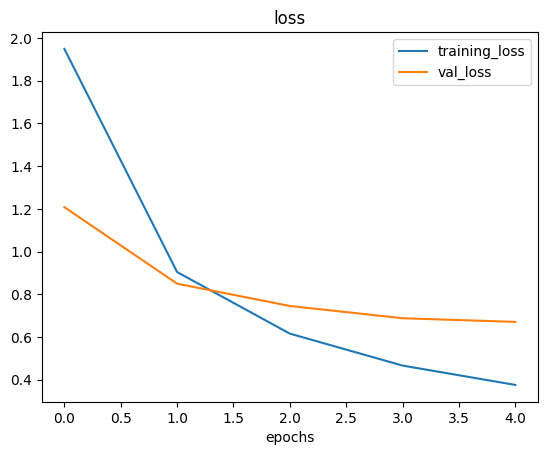

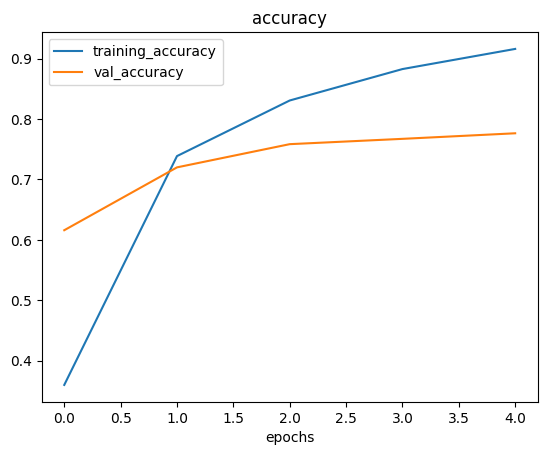

In [14]:
plot_loss_curves(history_1)

🔑**Note**- Should create a file called helper.py to hold functions like this to help when analyzing future model performances in the future.

###Creating and testing EfficentNetv2 hub so that we can compare it to the resnetv50 model

In [15]:
#All we have to do is change the url given to the create model function since we create
#a pipeline that loads in the pretrained model and creaye
efficientnet_model = create_model(model_url = efficientnet_url)

In [16]:
#Compile the model
efficientnet_model.compile(loss = CategoricalCrossentropy(),
                           optimizer = Adam(),
                           metrics = ["accuracy"])

In [17]:
#Fit the model
history_2 = efficientnet_model.fit(train_data_10_percent, epochs=5, steps_per_epoch=len(train_data_10_percent),
                                   validation_data = test_data, validation_steps=len(test_data),
                                     callbacks = [create_tensorboard_callback(dir_name = "tesorflow_hub",
                                                                      experiment_name = "efficientnetv2")])

Saving tensorBoard log files to tesorflow_hub/efficientnetv2/240202-213759
Epoch 1/5
24/24 [==============================] - 22s 556ms/step - loss: 1.9531 - accuracy: 0.3773 - val_loss: 1.4910 - val_accuracy: 0.6280
Epoch 2/5
24/24 [==============================] - 9s 401ms/step - loss: 1.3015 - accuracy: 0.6800 - val_loss: 1.1131 - val_accuracy: 0.7180
Epoch 3/5
24/24 [==============================] - 9s 407ms/step - loss: 1.0046 - accuracy: 0.7680 - val_loss: 0.9440 - val_accuracy: 0.7404
Epoch 4/5
24/24 [==============================] - 10s 420ms/step - loss: 0.8480 - accuracy: 0.8200 - val_loss: 0.8533 - val_accuracy: 0.7576
Epoch 5/5
24/24 [==============================] - 10s 426ms/step - loss: 0.7406 - accuracy: 0.8267 - val_loss: 0.7952 - val_accuracy: 0.7660


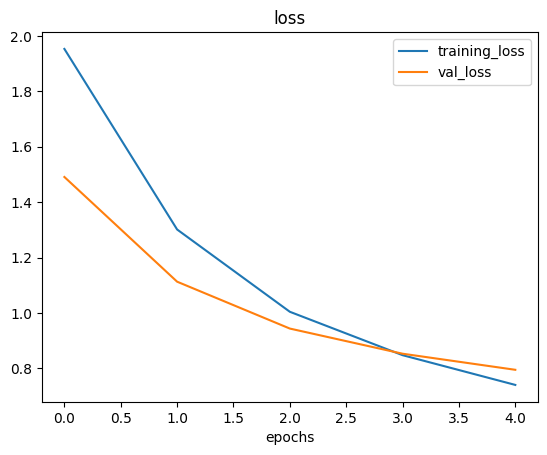

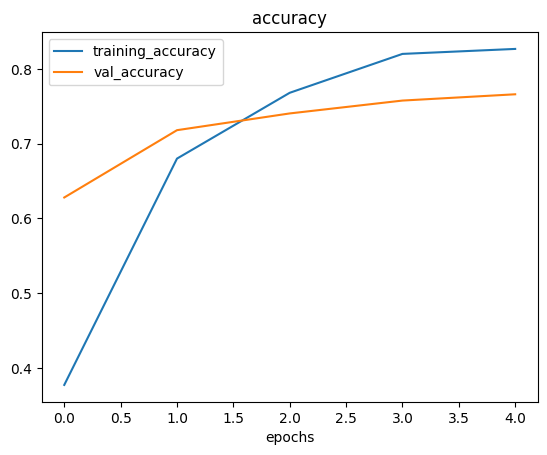

In [18]:
#Plot the loss curves of the efficientnet model
plot_loss_curves(history_2)

In [19]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_Extraction_Layer (  (None, 1280)              5919312   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


In [20]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_Extraction_Layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


🔑**Note**- Even though the `Resnet` model has a little over 5 times the numbers of parameters than the `efficientnet` model, the `efficientnet` model is still outperforming the `resnet` model.

### Different Types of **`Transfer Learning`**
* **`"As is" Transfer learning`** - Using an existing model with no changes what so ever(e.g. using `imagenet` model on 1000 `imagenet` classes, none of your own)
* **`"Feature Extraction" Transfer Learning`** - Using prelearned patterns of an existing model (e.g. efficientbetB0 trained on ImageNet) and adjust the `output layer` for your own problem(e.g. 1000 classes from imagenet -> 10 classes from our food dataset).
* **`"Fine Tuning" Transfer Learning`** - Use the prelearned patterns of the existing models and `fine tune` many or all of the `underlying layers` (including new output layers). `Fine tuning` typically requires more data than `feature extraction`.


In [21]:
#How many layers does our efficient net extractor have
print(f"These are all of the layers in the model: {efficientnet_model.layers}")
#We have two layers, the tensorflow hub keras layer and the Dense output layer

print(f"This is the amount of weights in the model: {len(efficientnet_model.layers[0].weights)}" ) #Weights is another word for patterns

These are all of the layers in the model: [<tensorflow_hub.keras_layer.KerasLayer object at 0x7e2270b13160>, <keras.src.layers.core.dense.Dense object at 0x7e21efcb39a0>]
This is the amount of weights in the model: 359


### Comparing our models results using TensorBoard

🔑**Note**- When you upload things to **tensorBoard.dev**, your experiments are public, so if you are running private experiments (things that you do not want others to see) do not upload them to tensorboard.dev .

In [22]:
#Upload tensorbaord dev records
!tensorboard dev upload --log_dir ./tensorflow_hub/ \
--name "efficientnetv2 vs resnet50v2" \
--description "Comparing two different TF hub feature extraction model architecture using 10% of the training data" \
--one_shot


2024-02-02 21:47:00.320086: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 21:47:00.320156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 21:47:00.321515: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 21:47:01.315248: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb